In [1]:
%matplotlib inline

import base64
import imageio
import json
import numpy as np
import requests
import matplotlib.pyplot as plt
import plotutils
import utils

In [2]:
def show_images(images, cols=1, titles=None):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    cols (Default = 1): Number of columns in figure (number of rows is
                        set to np.ceil(n_images/float(cols))).

    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [3]:
HOST = 'stargan-serving.eastus.azurecontainer.io'
PORT = 8501
MODEL_NAME = 'stargan'
MODEL_VERSION = '002'

attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
labels = [1, 0, 0, 1, 1]

attr2bin = {
    "Black_Hair": 1,
    "Blond_Hair": 1,
    "Brown_Hair": 1,
    "Male": 1,
    "Female": 0,
    "Young": 1,
    "Old": 0
}

attr2idx = {
    "Black_Hair": 0,
    "Blond_Hair": 1,
    "Brown_Hair": 2,
    "Male": 3,
    "Female": 3,
    "Young": 4,
    "Old": 4
}

In [4]:
def main(image_path, selected_attr):

    target_label = [1, 0, 0, 0, 1]
    for attr in selected_attr:
        if attr.endswith("Hair"):
            target_label[:3] = [0, 0, 0]

        target_label[attr2idx[attr]] = attr2bin[attr]


    input_bytes = open(image_path, "rb").read()
    b64_encoded_bytes = base64.b64encode(input_bytes)
    b64_encoded_str = b64_encoded_bytes.decode("utf-8")
    target_domain_label = np.array(target_label).reshape(1, -1)

    payload = {
        "inputs":{
            "input_bytes":{
                "b64": b64_encoded_str
            },
            "target_domain_label": target_domain_label.tolist(),
        }
    }

    r = requests.post("http://{}:{}/v1/models/{}/versions/{}:predict"
                      .format(HOST, PORT, MODEL_NAME, MODEL_VERSION),
                      json=payload)

    response = json.loads(r.content.decode("utf-8"))

    output_image_base64_str = response["outputs"]["b64"]
    output_image_bytes = base64.b64decode(output_image_base64_str)

    source_img = imageio.imread(input_bytes, pilmode="RGB")
    predicted_img = imageio.imread(output_image_bytes, pilmode="RGB")

    imgs = [source_img, predicted_img]
    titles = ["Original", "_".join(selected_attr)]
    show_images(imgs, titles=titles)

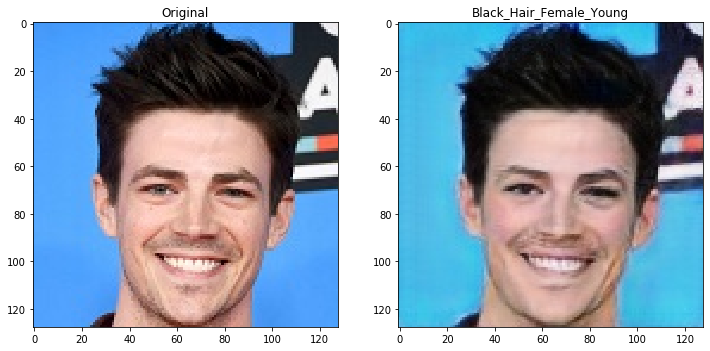

In [5]:
available_attr = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Female", "Young", "Old"]

IMAGE_PATH = "..\\dataset\\celebA\\test\\GrantGustin-2018.jpg"
selected_attr = ["Black_Hair", "Female", "Young"]

main(IMAGE_PATH, selected_attr)
